In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import imodels
import eval_feat_select
from collections import defaultdict
from typing import List
import dvu
import imodelsx
import imodelsx.viz
import imodelsx.llm
from pprint import pprint
import feat_select
import viz_feat_select

import openai
openai.api_key_path = '/home/chansingh/.OPENAI_KEY'
dvu.set_style()
outcome = 'tbi_old' # 'iai-i', 'tbi_young', 'tbi_old'
dset_dict = feat_select.DSET_DICTS[outcome]

In [2]:
X, y, feats_raw, feats_abbrev_unique = dset_dict['get_data'](outcome=outcome)
print(f"Unique features: {len(feats_abbrev_unique)}", 'X shape', X.shape)
print('Positive outcomes', y.sum())

# # plt.figure(figsize=(8, 12))
# # n = df_full.shape[1] - 1
# # plt.barh(y=np.arange(n), width=df_full.corr()["outcome"][:-1])
# # plt.yticks(np.arange(n), pd.Series(df_full.columns[:-1]).apply(lambda x: x[:20]))
# # plt.grid()
# # plt.show()

(42428,)
Unique features: 63 X shape (31707, 191)
Positive outcomes 278.0


Text(0, 0.5, 'Precision')

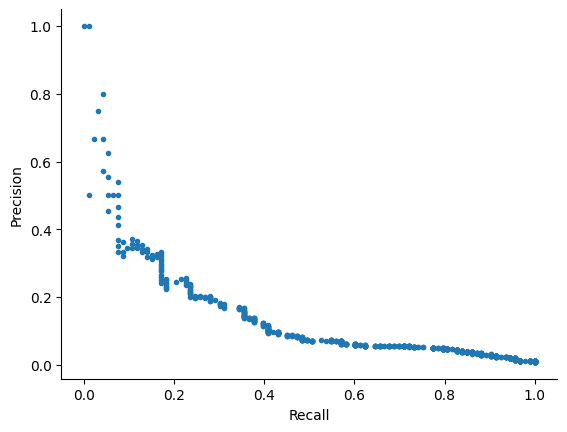

In [3]:
rng = np.random.default_rng(42)
# feats_select = rng.choice(list(feats_abbrev_unique), size=5, replace=False)
# feats_select = ['AbdTrauma']
feats_select = dset_dict['pecarn_feats_ordered']
idxs_raw = feat_select.abbrevs_to_idxs_raw(feats_select, feats_raw)

mets = eval_feat_select.evaluate_features(
    X[:, idxs_raw], y, seed=42, class_weight=2, return_pr_curve=True
)
prec, rec, thresh = mets['roc_auc_curve']
plt.plot(rec, prec, '.')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [4]:
def compute_mets_avg(strategies, feats_abbrev_unique, X, y, dset_dict, num_seeds=2):
    """Compute metrics when fitting a simple classifier
    using features selected from feats_abbrev_unique
    """
    mets_list_strategies = defaultdict(list)
    for strategy in tqdm(strategies):
        for seed in range(num_seeds):
            mets_seed = defaultdict(list)
            feats_ordered = feat_select.get_feats_ordered(
                feats_abbrev_unique, dset_dict, strategy=strategy, seed=seed
            )
            for i in range(len(feats_ordered)):
                feats_select = feats_ordered[: i + 1]
                idxs_raw = feat_select.abbrevs_to_idxs_raw(feats_select, feats_raw)
                met_scores = eval_feat_select.evaluate_features(
                    X[:, idxs_raw], y, seed=42 + seed
                )
                for k in met_scores:
                    mets_seed[k].append(met_scores[k])
                mets_seed["n_feats"].append(i + 1)
            mets_list_strategies[strategy].append(pd.DataFrame(mets_seed))

    # average over seed: convert mets_list_strategies to mets_avg
    mets_avg = defaultdict(list)
    for strategy in strategies:
        m = mets_list_strategies[strategy]
        cols = m[0].columns
        mets_mean = pd.DataFrame(
            data=np.mean([m[i].values for i in range(len(m))], axis=0),
            columns=cols,
        )
        mets_sem = pd.DataFrame(
            data=np.std([m[i].values for i in range(len(m))], axis=0) / np.sqrt(len(m)),
            columns=[k + "_sem" for k in cols],
        )
        mets_avg[strategy] = pd.concat([mets_mean, mets_sem], axis=1)

    return mets_avg

### Possibly-memorized plot

In [8]:
mets_avg = compute_mets_avg(
    ["gpt-4-0314", "pecarn", "random"], #, "pecarn___gpt-4-0314"],
    feats_abbrev_unique,
    X,
    y,
    dset_dict,
)

viz_feat_select.viz_curves(mets_avg, strategies=['pecarn', 'gpt-4-0314', 'random'], outcome=outcome, n_end=8)
plt.savefig(f'../results_llm/{outcome}_reselect_original.pdf')
# viz_feat_select.viz_curves(mets_avg, strategies=['gpt-4-0314', 'random'], outcome=outcome, n_end=8)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

abbrev {'AMSRepeat', 'LocLen', 'FontBulg', 'HA', 'SFxPalp', 'Seiz', 'SFxBasHem', 'AMSOth', 'SFxBasRet', 'ClavOcc', 'Intubated', 'VomitStart', 'ClavPar', 'HAStart', 'SFxPalpDepress', 'High', 'NeuroDOth', 'AMSSleep', 'ClavNeck', 'Amnesia', 'Clav', 'OSIExtremity', 'SFxBasPer', 'ClavFace', 'HemaSize', 'NeuroDReflex', 'Sedated', 'OSI', 'AgeTwoPlus', 'AgeinYears', 'SFxBasRhi', 'OSICspine', 'Gender', 'ClavTem', 'ClavFro', 'LOCSeparate', 'NeuroDMotor', 'AMS', 'NeuroDSensory', 'AMSAgitated', 'NeuroD', 'OSIPelvis', 'OSIFlank', 'InjuryMech', 'Hema', 'HemaLoc', 'OSIOth', 'VomitLast', 'Drugs', 'Paralyzed', 'SFxBas', 'Vomit', 'OSIAbdomen', 'VomitNbr', 'AMSSlow', 'HASeverity', 'SFxBasOto', 'OSICut', 'SeizLen', 'SeizOccur', 'AgeInMonth', 'ActNorm', 'NeuroDCranial'}
not cached


  0%|          | 0/3 [00:05<?, ?it/s]

prompt Return the following bulleted list in order of how each feature is for predicting intra-abdominal injury requiring intervention. First should be the most important.
- Altered mental status
- Basilar skull fracture
- Loss of consciousness
- Mechanism of injury
- Sever headache
- Vomiting


 ['Mechanism of injury', 'Altered mental status', 'Loss of consciousness', 'Basilar skull fracture', 'Severe headache', 'Vomiting'] 




AssertionError: 

### Extrapolating to new features plot

In [61]:
strategies = ["gpt-4-0314", "random"]
mets_avg = compute_mets_avg(
    strategies,
    [
        feat
        for feat in feats_abbrev_unique
        if not feat in dset_dict["pecarn_feats_ordered"]
    ],
    X,
    y,
    dset_dict,
)

  0%|          | 0/2 [00:00<?, ?it/s]

['AbdDistention', 'Age', 'CostalTender', 'DistractingPain', 'Hypotension', 'InitHeartRate', 'InitSysBPRange', 'MOI', 'Race', 'Sex', 'ThoracicTender']
{'AbdDistention': 'Abdominal distention', 'AbdTenderDegree': 'Degree of abdominal tenderness', 'AbdTrauma': 'Abdominal wall trauma', 'AbdomenPain': 'Abdominal pain', 'Age': 'Age', 'CostalTender': 'Costal margin tenderness', 'DecrBreathSound': 'Decreased breath sounds', 'DistractingPain': 'Distracting pain', 'GCSScore': 'GCS score', 'Hypotension': 'Hypotension', 'InitHeartRate': 'Heart rate', 'InitSysBPRange': 'Systolic blood pressure', 'LtCostalTender': 'Left costal tenderness', 'MOI': 'Mechanism of injury', 'Race': 'Race', 'RtCostalTender': 'Right costal tenderness', 'SeatBeltSign': 'Seatbelt sign', 'Sex': 'Sex', 'ThoracicTender': 'Thoracic tenderness', 'ThoracicTrauma': 'Thoracic trauma', 'VomitWretch': 'Vomiting'}
cached!
['AbdDistention', 'Age', 'CostalTender', 'DistractingPain', 'Hypotension', 'InitHeartRate', 'InitSysBPRange', 'MOI'

100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


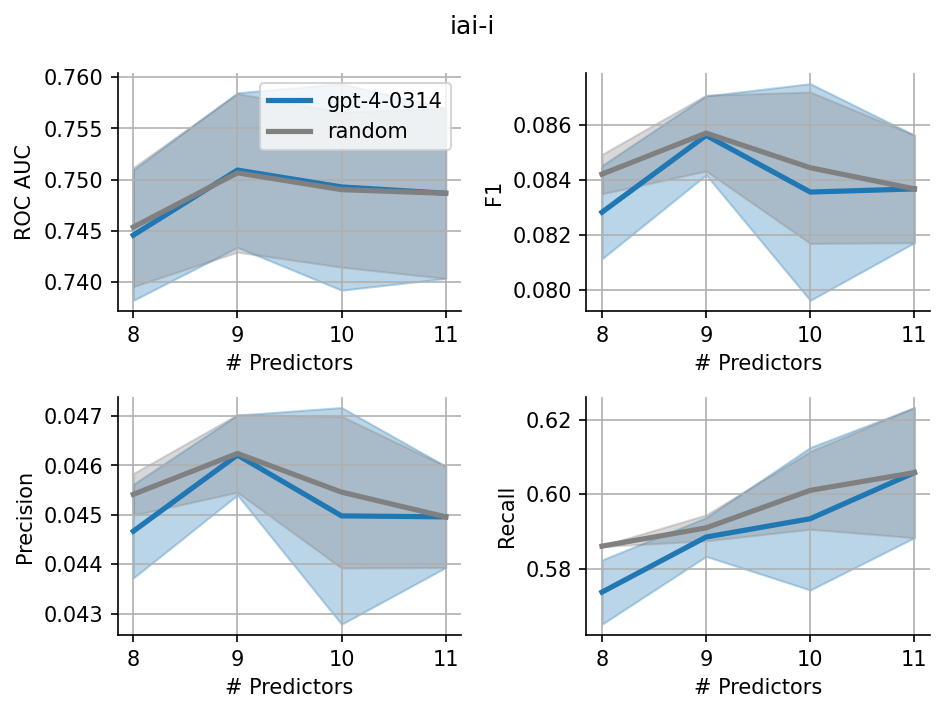

In [62]:
viz_feat_select.viz_curves(mets_avg, strategies=strategies, outcome=outcome, n_start=8-1)
plt.savefig(f'../results_llm/{outcome}_reselect_unused.pdf')
plt.show()